# Import libraries

In [0]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import cv2
import pickle
import random
import time
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/DL")
pd.set_option('display.max_rows', 5)
train_data_folder = './modified_kaggle_HW2/kaggle_train_128/train_128/'
test_data_folder = './modified_kaggle_HW2/kaggle_test_128/test_128/'
labels = pd.read_csv('./modified_kaggle_HW2/modified_prediction_labels_template.csv')
#five output classes
OUTPUT_DIM=5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Converting all data to pkl

In [0]:
#Loading data in pkl format for train, validation and prediction(only used for first time data preparation)
"""
for class_ in classes:
  trainset = []
  image_train_read(train_data_folder, class_, trainset)
  print('Saving to file for class ', class_)
  with open('trainset.pkl', 'ab') as f:
    pickle.dump(trainset, f)
  f.close()

#Loading data for test
testset = []
image_test_read(test_data_folder, testset)
with open('testset.pkl', 'ab') as f:
  pickle.dump(testset, f)
f.close()
"""

## Define all functions and NN models 

In [0]:
#load the labels
def load_labels():
  return ['0', '1', '2', '3', '4']

#read train data in CIFAR10 data format
def image_train_read(folder, class_, ls_):
  count = 1
  #read all the files in train directory
  for image in os.listdir(os.path.join(folder, class_)):
    print('Class : ', class_, ' Image count : ', count)
    img = cv2.imread(train_data_folder + class_ + '/' + image)
    #plt.imshow(img)
    ls_.append((img, int(class_)))
    count += 1

#read prediction/ test data in CIFAR10 data format
def image_test_read(folder, ls_):
  count = 1
  for image in os.listdir(folder):
    print('Image count : ', count)
    img = cv2.imread(test_data_folder + image)
    #plt.imshow(img)

    ls_.append((img, str(image)))
    count += 1

#calculate accuracy for predictions
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0 
    model.train()
    for (x, y) in iterator:    
        x = x.to(device)
        y = y.to(device)    
        optimizer.zero_grad()
        fx = model(x)
        loss = criterion(fx, y)
        acc = calculate_accuracy(fx, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device): 
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            fx = model(x)
            loss = criterion(fx, y)
            acc = calculate_accuracy(fx, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_model(model, EPOCHS=10, OUTPUT_DIM=5, outputModel='bottle-model-LeNet.pt'):
  best_valid_loss = float('inf')
  optimizer = optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  criterion = criterion.to(device)
  for epoch in range(EPOCHS):  
      start_time = time.time()
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), outputModel)
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

def class_accuracy(model, outputModel=''):
  net = model
  net.load_state_dict(torch.load(outputModel))
  class_correct = list(0. for i in range(OUTPUT_DIM))
  class_total = list(0. for i in range(OUTPUT_DIM))
  with torch.no_grad():
      for data in valid_iterator:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(OUTPUT_DIM):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

      for i in range(5):
        print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
      
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)   
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 10, 
                               kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 10, 
                               out_channels = 18, 
                               kernel_size = 5)
    
        self.fc1 = nn.Linear(18 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)    
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 5)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), #kernel_size
            nn.Conv2d(16, 64, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 256, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 64, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Load train data and calculate mean/std across the three channels

In [0]:
classes = load_labels()
trainset = []
with open('trainset.pkl', 'rb') as f:
  for class_ in classes:
    trainset.append(pickle.load(f))
trainset = sum(trainset,[])
trainset_data = np.asarray([img[0] for img in trainset]) 
means_train = trainset_data.mean(axis = (0,1,2)) / 255
stds_train = trainset_data.std(axis = (0,1,2)) / 255
print(f'Calculated means: {means_train}')
print(f'Calculated stds: {stds_train}')
del trainset_data

Calculated means: [0.39525004 0.4486831  0.49342256]
Calculated stds: [0.23845134 0.2440876  0.25452742]


In [0]:
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
testset_data = np.asarray([img[0] for img in testset]) 
means_test = testset_data.mean(axis = (0,1,2)) / 255
stds_test = testset_data.std(axis = (0,1,2)) / 255
print(f'Calculated means: {means_test}')
print(f'Calculated stds: {stds_test}')
del testset_data

Calculated means: [0.39354263 0.44758875 0.49312255]
Calculated stds: [0.2404389  0.24719865 0.25792148]


## Image Processing

In [0]:
train_transforms = transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomRotation(10),
                          #transforms.CenterCrop(64),
                          transforms.ToTensor(),
                          #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          transforms.Normalize(mean = means_train, 
                                              std = stds_train)
                       ])
#Torch tensor to PIL image
trans = transforms.ToPILImage()
trainset_transformed = []
for i in range(len(trainset)):
  trainset_transformed.append((train_transforms(trans(trainset[i][0])), trainset[i][1]))
  if i%400 == 0:
    print(i, ' images are processed')
del trainset

0  images are processed
400  images are processed
800  images are processed
1200  images are processed
1600  images are processed
2000  images are processed
2400  images are processed
2800  images are processed
3200  images are processed
3600  images are processed
4000  images are processed
4400  images are processed
4800  images are processed
5200  images are processed
5600  images are processed
6000  images are processed
6400  images are processed
6800  images are processed
7200  images are processed
7600  images are processed
8000  images are processed
8400  images are processed
8800  images are processed
9200  images are processed
9600  images are processed
10000  images are processed
10400  images are processed
10800  images are processed
11200  images are processed
11600  images are processed
12000  images are processed
12400  images are processed
12800  images are processed
13200  images are processed
13600  images are processed
14000  images are processed
14400  images are proc

In [0]:
test_transforms = transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomRotation(10),
                          #transforms.CenterCrop(64),
                          transforms.ToTensor(),
                          #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          transforms.Normalize(mean = means_test, 
                                              std = stds_test)
                       ])
trans = transforms.ToPILImage()
testset_transformed = []
for i in range(len(testset)):
  testset_transformed.append((test_transforms(trans(testset[i][0])), testset[i][1]))
  if i%400 == 0:
    print(i, ' images are processed')
del testset

0  images are processed
400  images are processed
800  images are processed
1200  images are processed
1600  images are processed
2000  images are processed
2400  images are processed
2800  images are processed
3200  images are processed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


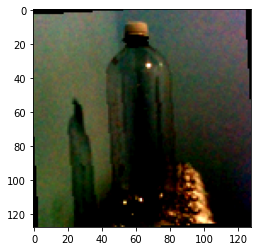

In [0]:
#check images
img = trainset_transformed[2][0]
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [0]:
n_train_examples = int(len(trainset_transformed)*0.9)
n_valid_examples = len(trainset_transformed) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(trainset_transformed, 
                                                       [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(testset_transformed)}')

Number of training examples: 13517
Number of validation examples: 1502
Number of testing examples: 3500


## Define train/ valid and test iterator in batches

In [0]:
BATCH_SIZE = 128
train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(testset_transformed,
                                           batch_size = 1)

## LeNet

In [0]:
model = LeNet(OUTPUT_DIM)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')
train_model(model, EPOCHS=15, OUTPUT_DIM=5, outputModel='bottle-LeNet.pt')

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 18, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)
The model has 71,193 trainable parameters
Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.119 | Train Acc: 55.11%
	 Val. Loss: 0.841 |  Val. Acc: 67.27%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.754 | Train Acc: 72.25%
	 Val. Loss: 0.707 |  Val. Acc: 74.24%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.596 | Train Acc: 78.68%
	 Val. Loss: 0.614 |  Val. Acc: 78.91%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.499 | Train Acc: 82.55%
	 Val. Loss: 0.513 |  Val. Acc: 82.78%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.420 | Train Acc: 85.40%
	 Val. Loss: 0.520 |  Val. Acc: 81.60%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.36

## AlexNet

In [0]:
model = AlexNet(OUTPUT_DIM)
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')
train_model(model, EPOCHS=15, OUTPUT_DIM=5, outputModel='bottle-AlexNet.pt')

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=F

### Preditc accuracy for each class

In [0]:
print('Class accuracy with LeNet: ')
class_accuracy(model=LeNet(OUTPUT_DIM), outputModel='bottle-LeNet.pt')
print("====================")
print('Class accuracy with AlexNet: ')
class_accuracy(model=AlexNet(OUTPUT_DIM), outputModel='bottle-AlexNet.pt')

Class accuracy with LeNet: 
Accuracy of     0 : 83 %
Accuracy of     1 : 86 %
Accuracy of     2 : 100 %
Accuracy of     3 : 93 %
Accuracy of     4 : 100 %
Class accuracy with AlexNet: 
Accuracy of     0 : 83 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 93 %
Accuracy of     4 : 77 %


In [0]:
#prediction for test set
net = AlexNet(OUTPUT_DIM)
net.load_state_dict(torch.load('bottle-AlexNet.pt'))
pred = []
with torch.no_grad():
    for data in test_iterator:
        images, png = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        #print(png[0], ' ', predicted.item())
        pred.append((png[0], predicted.item()))
df = pd.DataFrame(pred, columns=['Id', 'label'])
df.to_csv('submission.csv', index=None)